
# Code for Speed Optimization

In [43]:

import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [44]:
import shutil
import os

base_dirs = ["/content/smalll_train", "/content/smalll_val"]

remove_folders = ["glioma", "meningioma", "pituitary", "notumor"]

for base in base_dirs:
    for folder in remove_folders:
        path = os.path.join(base, folder)
        if os.path.exists(path):
            shutil.rmtree(path)
            print("Removed:", path)


# Making fresh contents inside folders 

In [45]:
# import shutil 
# shutil.rmtree("/content/small_dataaset", ignore_errors=True)
# shutil.rmtree("/content/small_train", ignore_errors=True)
# shutil.rmtree("/content/small_val", ignore_errors=True)


# Extracting our Zip files.

In [46]:
import zipfile
import os

zip_path = "binary_mri.zip"          # uploaded file ka naam
extract_path = "/content/PPset" # at whch directory
                                  # we have to extract
os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction done! Files are in:", extract_path)

Extraction done! Files are in: /content/PPset


In [47]:
print(os.listdir(extract_path))

['binary_mri']


# Important libraries

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

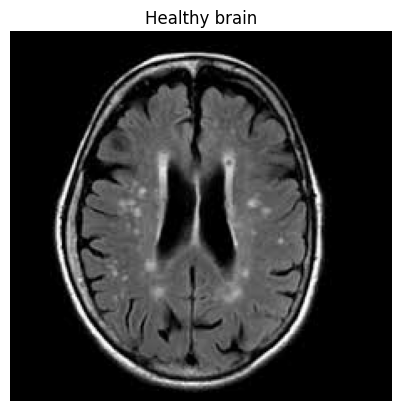

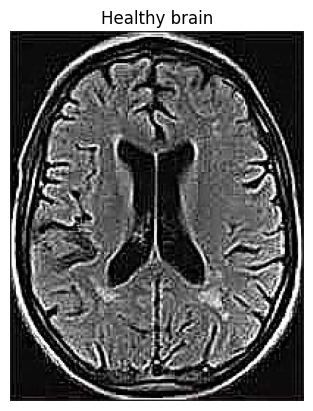

In [49]:
import os, random, matplotlib.pyplot as plt, matplotlib.image as mpimg
N = "/content/pPset/binary_mri/no"
for i in random.sample(os.listdir(N), 2):
    plt.imshow(mpimg.imread(os.path.join(N, i)), cmap='gray')
    plt.title("Healthy brain")
    plt.axis('off')
    plt.show()


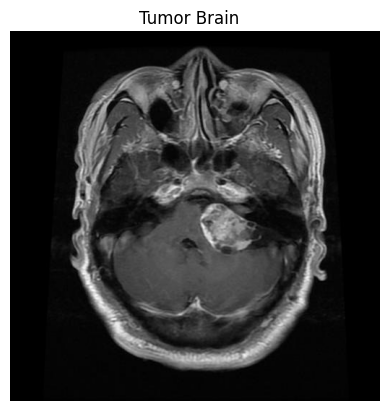

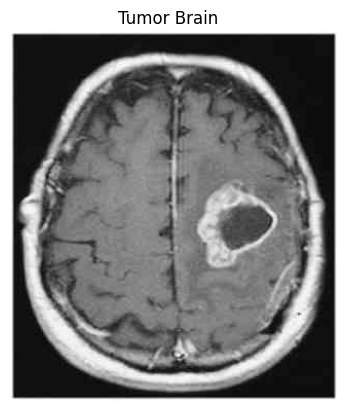

In [50]:
import os, random, matplotlib.pyplot as plt, matplotlib.image as mpimg
Y = "/content/pPset/binary_mri/yes"
for i in random.sample(os.listdir(Y), 2):
    plt.imshow(mpimg.imread(os.path.join(Y, i)), cmap='gray')
    plt.title("Tumor Brain  ")
    plt.axis('off')
    plt.show()


# Random Image Displaying From Every Class

# Taking  Dataset Into Chunks

In [51]:
import os

subset_base = "/content/pPset/binary_mri"
classes = ["no", "yes",]

for cls in classes:
    path = os.path.join(subset_base, cls)
    count = len(os.listdir(path))
    print(f"{cls} images:", count)

no images: 587
yes images: 576


# Train validation split

In [52]:
from sklearn.model_selection import train_test_split

train_dir = "/content/smaal_train"
val_dir   = "/content/smaal_val"

os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for cls in classes:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    images = os.listdir(os.path.join(subset_base, cls))
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(subset_base, cls, img),
                    os.path.join(train_dir, cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(subset_base, cls, img),
                    os.path.join(val_dir, cls, img))


In [53]:
import os

train_dir = "/content/smaal_train"
classes = ["no", "yes"]

for cls in classes:
    path = os.path.join(train_dir, cls)
    count = len(os.listdir(path))
    print(f"{cls} train images:", count)


no train images: 469
yes train images: 460


In [54]:
import os

val_dir = "/content/smaal_val"   # tumhara validation directory
classes = ["no", "yes"]

for cls in classes:
    path = os.path.join(val_dir, cls)
    count = len(os.listdir(path))
    print(f"{cls} images in validation:", count)


no images in validation: 118
yes images in validation: 116


In [55]:
import os

train_dir = "/content/smaal_train"   # ya jo bhi path hai
val_dir   = "/content/smaal_val"

print(" FOLDER:")
print(os.listdir(train_dir))

print("\nVALIDATION FOLDER:")
print(os.listdir(val_dir))


 FOLDER:
['no', 'yes']

VALIDATION FOLDER:
['no', 'yes']


# Loading &  Processing Data

In [56]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(224, 224),
    batch_size=16,
    label_mode="binary",
    shuffle=True,
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(224, 224),
    batch_size=16,
    label_mode="binary",
    shuffle=False
)


                
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
 

Found 929 files belonging to 2 classes.
Found 234 files belonging to 2 classes.


# Augmentation

In [57]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.15),
], name="augmentation")


# Pretrained Model

In [58]:
base_model = tf.keras.applications.EfficientNetB3(
    weights="imagenet",
    include_top=False,
    input_shape=(224, 224, 3)
)

base_model.trainable = False



In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers


model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    base_model,

    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),

    layers.Dense(512, activation="relu"),
    layers.Dropout(0.3),

    layers.Dense(1, activation="sigmoid")   # binary output
])


In [60]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)



In [61]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        "binary2_model.keras",
        save_best_only=True
    )
]



In [62]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=callbacks
)


Epoch 1/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 44s 548ms/step - accuracy: 0.6792 - loss: 0.6382 - val_accuracy: 0.5085 - val_loss: 0.6434
Epoch 2/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 29s 496ms/step - accuracy: 0.6986 - loss: 0.6301 - val_accuracy: 0.8291 - val_loss: 0.6140
Epoch 3/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 30s 514ms/step - accuracy: 0.7395 - loss: 0.5655 - val_accuracy: 0.8205 - val_loss: 0.5845
Epoch 4/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 569ms/step - accuracy: 0.7449 - loss: 0.5420 - val_accuracy: 0.8120 - val_loss: 0.5515
Epoch 5/5
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 536ms/step - accuracy: 0.7277 - loss: 0.5654 - val_accuracy: 0.8077 - val_loss: 0.5209


In [87]:
base_model.trainable = True

# Sirf last 30 layers trainable
for layer in base_model.layers[:-30]:
    layer.trainable = False


In [64]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [65]:
history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)


Epoch 1/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 49s 607ms/step - accuracy: 0.6383 - loss: 0.6884 - val_accuracy: 0.7137 - val_loss: 0.5263
Epoch 2/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 568ms/step - accuracy: 0.6889 - loss: 0.6107 - val_accuracy: 0.7179 - val_loss: 0.5230
Epoch 3/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 572ms/step - accuracy: 0.7212 - loss: 0.5591 - val_accuracy: 0.7308 - val_loss: 0.5231
Epoch 4/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 33s 568ms/step - accuracy: 0.7234 - loss: 0.5631 - val_accuracy: 0.7222 - val_loss: 0.5609
Epoch 5/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 572ms/step - accuracy: 0.7169 - loss: 0.5796 - val_accuracy: 0.7479 - val_loss: 0.4942
Epoch 6/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 547ms/step - accuracy: 0.7244 - loss: 0.5644 - val_accuracy: 0.7350 - val_loss: 0.5112
Epoch 7/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 34s 574ms/step - accuracy: 0.7223 - loss: 0.5813 - val_accuracy: 0.7564 - val_loss: 0.4868
Epoch 8/10
59/59 ━━━━━━━━━━━━━━━━━━━━ 32s 540ms/step - accuracy: 0.7427 - loss: 0.5499 - val_accu

In [89]:

model.save("binary2_model.keras")


# Loading the Dataset and processing

In [67]:
# # Step 1: Imports
# import tensorflow as tf
# from tensorflow.keras import layers, models, Sequential
# import matplotlib.pyplot as plt

# base_model = tf.keras.applications.EfficientNetB3(
#     weights='imagenet',
#     include_top=False,
#     input_shape=(224,224,3)
# )


# base_model.trainable = False

# model = tf.keras.Sequential([
#     data_augmentation, 
#     tf.keras.layers.Rescaling(1./255),
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(1, activation='sigmoid')
# ])


# model.compile(
#     optimizer=tf.keras.optimizers.Adam(1e-4),
#     loss='binary_crossentropy',
#     metrics=['accuracy']
# )



# Defining Data Augmentation

In [68]:
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(
#         patience=5,
#         restore_best_weights=True
#     ),
#     tf.keras.callbacks.ModelCheckpoint(
#         "binary_mri_model.keras",
#         save_best_only=True
#     )
# ]



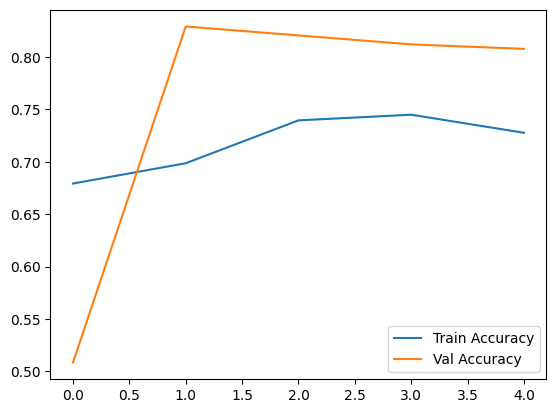

In [69]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.show()


# Loading Pretrained Model

In [70]:
# base_model = tf.keras.applications.EfficientNetB3(
#     weights='imagenet',
#     include_top=False,                                     
#     input_shape=(224, 224, 3) 
# )                             
                            



         # Means we are removing last layer of                              
         # image net ..last layer means
         # classifing or giving output probability
         # for classes ..we are removing because 
         # we do not want the probabiliy of imagenet
         # dataset. we just want to 
         # learn the faetures , edges from
         # other dataset . we turned off the last layer 
         # of this because we will use last layer (our custom layer)
         # for our dataset to tune the model 



# Defining  Callbacks 

In [71]:
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True),
#     tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
#     tf.keras.callbacks.ModelCheckpoint("we_model.keras", save_best_only=True, monitor="val_loss")
# ]

# # Patience  = 7 means ,  epoch = 7 ..its is threshhold. , if 
# # there is no change in accuracy in next 7 epoch model will 
# # be stopped from being trained.

# #            ReduceLROnPlateau =  If from first 3 epoch
# #                                 there is no major change
# #                   trainig accuracy or validation then ...it will
# #                   halfen the assigned the learning rate ...
# #                   if there is still a problem in next 4 epoch
# #                   means there is no major change in next 4 epochs 
# #                   then ..it will copletely stopped the model 
# #                   from being train .



In [72]:
# # Class weights add kar (bias fix ke liye)
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Train generator se labels nikaal
# train_labels = np.concatenate([y for x, y in train_ds], axis=0)
# train_classes = np.argmax(train_labels, axis=1)

# class_weights = compute_class_weight(
#     class_weight='balanced',
#     classes=np.unique(train_classes),
#     y=train_classes
# )
# class_weights = dict(enumerate(class_weights))

# print("Class Weights:", class_weights)
# # Output kuch aisa aayega: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0} – balanced hai to same, lekin agar imbalance hota to adjust karta

# Model Architecture (Top Layers)

In [73]:
# num_classes = len(os.listdir(train_dir)) # here we are defining number 
#                                          # of classes . 


  
# # our  convolution architeture.
# # our last layer which i  have to train .

# model = Sequential([
#     layers.Input(shape=(224,224,3)),
#     data_augmentation,
#     layers.Rescaling(1./255),
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),          # 0.3 se 0.5 kiya (overfitting rokega)
#     layers.Dense(512, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.4),          # 0.2 se 0.4
#     layers.Dense(num_classes, activation='softmax') 
# ])
# # code :
#      # layers.Dense(num_classes, activation='softmax') 

# # explanation : 

# #  Last layer → this  layer is known as last layer :
# # this  is ihe ouput  layer of my dataset ..

# # This last layer roughly decides which class an image belongs to.
# # Basically, it maps the features 
# # extracted by the base model (edges, textures, patterns)
# # to the class labels of your dataset.
# # During the first 5 epochs, 
# # it only performs this initial adjustment, 
# # serving as a basic mapping between features and labels.



# # 512 nuerons means 512 diffrent observaton in just 
# # one image.


# # important 
#           # we can  replace num_classes to 4.


# Compiling and Training The Last Layer.

In [74]:
# base_model.trainable = False # our pretrained base model layer
#                              # which will not be updated while 
#                              # compiling

# model.compile(         
#     optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

#    # Here we have done base model(efficientNet B3)
#    # false Because we do not want retrain the 
#    # the base model or update. 
#    # it already trained and have 
#    # the Knowledges of Features , edges on Millions of images 
#    # Dataset. So that why we turned Base Model false .

#  # in  inside our model base model is already included 

# Fitting The Last Layer

In [75]:
# history = model.fit(train_ds, 
#                     validation_data=val_ds,
#                     epochs=5, 
#                     callbacks=callbacks)

# # here we are fitting the compilation.
# #  in this we have  already freezed the base model 


# # here we have given only 5 epochs because
# # This last layer roughly decides which class an image belongs to.

# # Basically, it maps the features extracted
# # by the base model (edges, textures, patterns) 
# # to the class labels of your dataset.

# # During the first 5 epochs,
# # it only performs this initial adjustment,
# # serving as a basic mapping between features and labels.

# Fine-Tuning (Unfreeze Last Layers)

In [76]:
# base_model.trainable = True

# # Pehle 50 layers freeze, baaki unfreeze (better adaptation)
# fine_tune_at = 50   # 100 se 50 kar diya (zyada layers train honge)

# for layer in base_model.layers[:fine_tune_at]:
#     layer.trainable = False

# print(f"Unfreezing layers from {fine_tune_at} onwards")
#   # exlanation:
# # We are freezing the first 100 layers of the base model because 
# # these bottom layers detect simple features (edges, colors, textures) 
# # which are already learned and do not need retraining.

# # Now, only the top layers of the base model will be trainable.
# # These top layers detect complex patterns, and they will adapt to 
# # our dataset to recognize its specific complex features.
# # We assigned these top layers because they already have knowledge 
# # of complex patterns from pre-training and can easily adjust 
# # to our dataset.

# final compilation for last layer 

In [77]:
# model.compile(
#     optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),  # 1e-4 se 5e-5 (aur stable)
#     loss='categorical_crossentropy',
#     metrics=['accuracy'] 
# )

# final fitting for our last  layer 

In [78]:
# fine_history = model.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs = 25,  # 30 se 50 kar sakta hai agar Colab allow kare
#     callbacks=callbacks,
#     class_weight=class_weights  # Ye line add kar de
# )

# # here we are training the top layers 
# # of our model ....this top layers 
# # is of base model (pretrained model)
# # this layer is already have knowledge 
# # of comoplex features .


# Loading Test Data

In [79]:
# test_dir = "/content/dataaset/Testing"

# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_dir,
#     image_size=(224, 224),
#     batch_size=32,
#     shuffle=False  # test me shuffle mat karo
# )


In [80]:
# import os

# test_dir = "/content/dataaset/Testing"
# classes = ["notumor", "pituitary", "meningioma", "glioma"]

# for cls in classes:
#     path = os.path.join(test_dir, cls)   # yahan test_dir lagana hoga
#     count = len(os.listdir(path))
#     print(f"{cls} images:", count)


In [81]:
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# test_datagen = ImageDataGenerator(rescale=1./255)

# test_generator = test_datagen.flow_from_directory(
#     "/content/small_test_dataset",
#     target_size=(224,224),
#     batch_size=1,
#     class_mode='categorical',
#     shuffle=False,
#     classes=["notumor", "pituitary", "meningioma", "glioma"]  # TRAIN order
# )

In [82]:
# test_dir = "/content/small_test_dataset"

# test_ds = tf.keras.utils.image_dataset_from_directory(
#     test_dir,
#     image_size=(224,224),
#     batch_size=16,
#     label_mode='categorical',
#     shuffle=False,          # important
#     seed=123
# )

# test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# # Predictions
# preds = model.predict(test_ds)
# pred_classes = np.argmax(preds, axis=1)
# true_classes = np.argmax(np.concatenate([y for x, y in test_ds], axis=0), axis=1)

# accuracy = np.mean(pred_classes == true_classes) * 100
# print(f"Test Accuracy: {accuracy:.2f}%")

In [83]:

# class_names = ["notumor", "pituitary", "meningioma", "glioma"]

# from sklearn.metrics import confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Confusion matrix
# cm = confusion_matrix(true_classes, pred_classes)

# # Plot
# plt.figure(figsize=(8,6))
# sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix')
# plt.show()


In [84]:
# class_names = ["notumor", "pituitary", "meningioma", "glioma"]

# from sklearn.metrics import classification_report

# print(classification_report(true_classes, pred_classes, target_names=class_names))



In [85]:
# import pandas as pd
# import numpy as np

# # Tumhare class names
# class_names = ["notumor", "pituitary", "meningioma", "glioma"]

# #  Model predictions
# pred_probs = model.predict(test_ds)
# pred_classes = np.argmax(pred_probs, axis=1)

# #  True labels
# true_classes = np.concatenate([y for x, y in test_ds], axis=0)
# true_classes = np.argmax(true_classes, axis=1)

# #  Convert indices to class names
# true_labels = [class_names[i] for i in true_classes]
# pred_labels = [class_names[i] for i in pred_classes]

# #  Create DataFrame
# df = pd.DataFrame({
#     "True_Label": true_labels,
#     "Predicted_Label": pred_labels
# })

# #  Save CSV
# df.to_csv("predictions.csv", index=False)

# print("CSV file saved as predictions.csv")


In [86]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import classification_report

# # Class names
# class_names = ["notumor", "pituitary", "meningioma", "glioma"]

# # True labels
# true_classes = np.concatenate([y for x, y in test_ds], axis=0)
# true_classes = np.argmax(true_classes, axis=1)

# # Model predictions
# pred_probs = model.predict(test_ds)
# pred_classes = np.argmax(pred_probs, axis=1)

# # Convert numeric labels to class names
# true_labels = [class_names[i] for i in true_classes]
# pred_labels = [class_names[i] for i in pred_classes]

# # Classification report as dictionary
# report_dict = classification_report(true_classes, pred_classes, target_names=class_names, output_dict=True)

# # Create DataFrame for metrics
# metrics_df = pd.DataFrame(report_dict).transpose()

# # Save classification metrics to CSV
# metrics_df.to_csv("classification_metrics.csv", index=True)
# print("Classification metrics saved as classification_metrics.csv")

